# Monte Carlo Tree Search Algorithm for the Game "2048"

c: Irina-Mona Epure [irinamonaepure@gmail.com]()

The end of the semester is approaching and it's time for you to look back on your good times and your bad times. You should remember all the good memories of your time in university and even go as far back as high-school. Maybe you could even go as far as the year 2014, when there was absolutely no pandemic in sight. <br> <br> <br> 

Except one... <br><br><br>

## The 2048 pandemic....

<br>

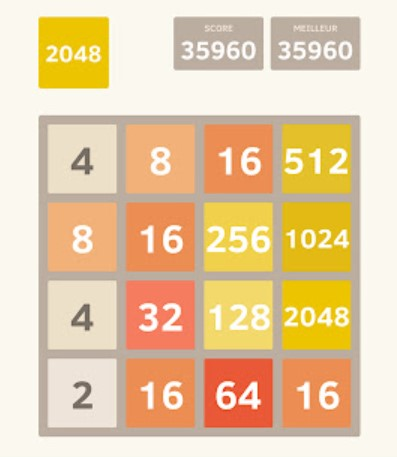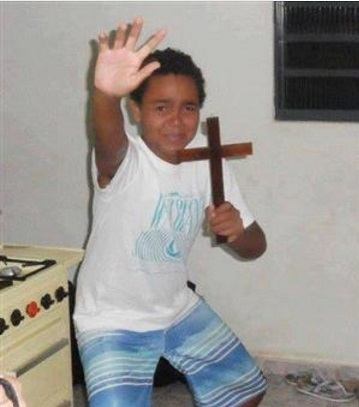

<br>

If you're like me and you've never managed to beat [this game](https://play2048.co/) before, then today is your lucky day! It's time for you to face your demons and use your brain to create a program that will beat the game for you in order to assert your supremacy! Take that, 2048!

<br>

Don't be intimidated by the length of this notebook! I know I went overboard. But you don't actually need to implement the game itself. That part is already done due to this awesome tutorial [here](https://www.youtube.com/watch?v=b4XP2IcI-Bg). <br>

Your task will be to modify the [Monte Carlo Tree Search algorithm](http://ccg.doc.gold.ac.uk/ccg_old/papers/browne_tciaig12_1.pdf) from Homework 2 to suit the 2048 game. Some elements from the Game class that you should pay attention to in order to do that are the following: <br>

 - the methods <b>left</b>, <b>right</b>, <b>up</b> and <b>down</b>. These are the actions that your MCTS player will be able to perform. They should be called by your MCTS player;
 - the methods <b>horizontal_move_exists</b> and <b>vertical_move_exists</b> to check if the right and left or up and down moves are available, respectively. Your MCTS player can use these in order to figure out which moves are available;
 - the <b>utility</b> attribute which gives us the utility of a certain configuration for the player (1 if winning, -1 if losing an 0 otherwise). This attribute's value is updated in the <b>game_over</b> method, which is called after every move. Your MCTS player can use this value to evaluate the utility of a certain move. <br>
 
With these in mind, go ahead and take a very quick look at the game implementation in order to identify these elements.

In [39]:
import tkinter as tk # Needed for the GUI
import random
import numpy as np

In [40]:
# You'll need a bunch of helper functions first. I'll give them to you because I'm nice.
# Pay attention to the functions initialize_game(), move_down(), move_left(), move_right(), move_up(), add_new_tile(),
# check_for_win() and random_move()



POSSIBLE_MOVES_COUNT = 4
CELL_COUNT = 4
NUMBER_OF_SQUARES = CELL_COUNT * CELL_COUNT
NEW_TILE_DISTRIBUTION = np.array([2, 2, 2, 2, 2, 2, 2, 2 ,2, 4])

def initialize_game():
    board = np.zeros((NUMBER_OF_SQUARES), dtype="int")
    initial_twos = np.random.default_rng().choice(NUMBER_OF_SQUARES, 2, replace=False)
    board[initial_twos] = 2
    board = board.reshape((CELL_COUNT, CELL_COUNT))
    return board

def push_board_right(board):
    new = np.zeros((CELL_COUNT, CELL_COUNT), dtype="int")
    done = False
    for row in range(CELL_COUNT):
        count = CELL_COUNT - 1
        for col in range(CELL_COUNT - 1, -1, -1):
            if board[row][col] != 0:
                new[row][count] = board[row][col]
                if col != count:
                    done = True
                count -= 1
    return (new, done)


def merge_elements(board):
    score = 0
    done = False
    for row in range(CELL_COUNT):
        for col in range(CELL_COUNT - 1, 0, -1):
            if board[row][col] == board[row][col-1] and board[row][col] != 0:
                board[row][col] *= 2
                score += board[row][col]
                board[row][col-1] = 0
                done = True
    return (board, done, score)


def move_up(board):
    rotated_board = np.rot90(board, -1)
    pushed_board, has_pushed = push_board_right(rotated_board)
    merged_board, has_merged, score = merge_elements(pushed_board)
    second_pushed_board, _ = push_board_right(merged_board)
    rotated_back_board = np.rot90(second_pushed_board)
    move_made = has_pushed or has_merged
    return rotated_back_board, move_made, score

    
def move_down(board):
    board = np.rot90(board)
    board, has_pushed = push_board_right(board)
    board, has_merged, score = merge_elements(board)
    board, _ = push_board_right(board)
    board = np.rot90(board, -1)
    move_made = has_pushed or has_merged
    return board, move_made, score


def move_left(board):
    board = np.rot90(board, 2)
    board, has_pushed = push_board_right(board)
    board, has_merged, score = merge_elements(board)
    board, _ = push_board_right(board)
    board = np.rot90(board, -2)
    move_made = has_pushed or has_merged
    return board, move_made, score


def move_right(board):
    board, has_pushed = push_board_right(board)
    board, has_merged, score = merge_elements(board)
    board, _ = push_board_right(board)
    move_made = has_pushed or has_merged
    return board, move_made, score


def fixed_move(board):
    move_order = [move_left, move_up, move_down, move_right]
    for func in move_order:
        new_board, move_made, _ = func(board)
        if move_made:
            return new_board, True
    return board, False


def random_move(board):
    move_made = False
    move_order = [move_right, move_up, move_down, move_left]
    while not move_made and len(move_order) > 0:
        move_index = np.random.randint(0, len(move_order))
        move = move_order[move_index]
        board, move_made, score  = move(board)
        if move_made:
            return board, True, score
        move_order.pop(move_index)
    return board, False, score


def add_new_tile(board):
    tile_value = NEW_TILE_DISTRIBUTION[np.random.randint(0, len(NEW_TILE_DISTRIBUTION))]
    tile_row_options, tile_col_options = np.nonzero(np.logical_not(board))
    tile_loc = np.random.randint(0, len(tile_row_options))
    board[tile_row_options[tile_loc], tile_col_options[tile_loc]] = tile_value
    return board


def check_for_win(board):
    return 2048 in board

In [48]:
EDGE_LENGTH = 400
CELL_COUNT = 4
CELL_PAD = 10

UP_KEY = "'w'"
DOWN_KEY = "'s'"
LEFT_KEY = "'a'"
RIGHT_KEY= "'d'"
AI_KEY = "'q'"
AI_PLAY_KEY = "'p'"

LABEL_FONT = ("Helvetica", 40, "bold")

GAME_COLOR = "#a39489"

EMPTY_COLOR = "#c2b3a9"

TILE_COLORS = {
    2: "#fcefe6",
    4: "#f2e8cb",
    8: "#f5b682",
    16: "#f29446",
    32: "#ff775c",
    64: "#e64c2e",
    128: "#ede291",
    256: "#fce130",
    512: "#ffdb4a",
    1024: "#f0b922",
    2048: "#fad74d"
}

LABEL_COLORS = {
    2: "#695c57",
    4: "#695c57",
    8: "#ffffff",
    16: "#ffffff",
    32: "#ffffff",
    64: "#ffffff",
    128: "#ffffff",
    256: "#ffffff",
    512: "#ffffff",
    1024: "#ffffff",
    2048: "#ffffff"
}

class Display(Frame):
    def __init__(self):
        Frame.__init__(self)

        self.grid()
        self.master.title('2048')
        self.master.bind("<Key>", self.key_press)

        self.commands = {UP_KEY: move_up, 
                         DOWN_KEY: move_down,
                         LEFT_KEY: move_left, 
                         RIGHT_KEY: move_right,
# After you've implemented the MCTS player, come back and uncomment this line
#                         AI_KEY: mcts_move
                         }
        
        self.grid_cells = []
        self.build_grid()
        self.init_matrix()
        self.draw_grid_cells()

        self.mainloop()

    def build_grid(self):
        background = tk.Frame(self, bg=GAME_COLOR,
                           width=EDGE_LENGTH, height=EDGE_LENGTH)
        background.grid()

        for row in range(CELL_COUNT):
            grid_row = []
            for col in range(CELL_COUNT):
                cell = tk.Frame(background, bg=EMPTY_COLOR,
                             width=EDGE_LENGTH / CELL_COUNT,
                             height=EDGE_LENGTH / CELL_COUNT)
                cell.grid(row=row, column=col, padx=CELL_PAD,
                          pady=CELL_PAD)
                t = tk.Label(master=cell, text="",
                          bg=EMPTY_COLOR,
                          justify=tk.CENTER, font=LABEL_FONT, width=5, height=2)
                t.grid()
                grid_row.append(t)

            self.grid_cells.append(grid_row)

    def init_matrix(self):
        self.matrix = initialize_game()

    def draw_grid_cells(self):
        for row in range(CELL_COUNT):
            for col in range(CELL_COUNT):
                tile_value = self.matrix[row][col]
                if not tile_value:
                    self.grid_cells[row][col].configure(
                        text="", bg=EMPTY_COLOR)
                else:
                    self.grid_cells[row][col].configure(text=str(
                        tile_value), bg=TILE_COLORS[tile_value],
                        fg=LABEL_COLORS[tile_value])
        self.update_idletasks()
    
    def key_press(self, event):
        valid_game = True
        key = repr(event.char)
# After you've implemented the MCTS player, come back and uncomment this section
#        if key == AI_PLAY_KEY:
#            move_count = 0
#            while valid_game:
#                self.matrix, valid_game = mcts_move(self.matrix,40, 30)
#                if valid_game:
#                    self.matrix = add_new_tile(self.matrix)
#                    self.draw_grid_cells()
#                move_count += 1
#        if key == AI_KEY:
#            self.matrix, move_made = mcts_move(self.matrix, 20, 30)
#            if move_made:
#                self.matrix = add_new_tile(self.matrix)
#                self.draw_grid_cells()
#                move_made = False

        if key in self.commands:
            self.matrix, move_made, move_score = self.commands[repr(event.char)](self.matrix)
            if move_made:
                self.matrix = add_new_tile(self.matrix)
                self.draw_grid_cells()
                move_made = False


# Task 0

Stop right there! Your first task is to run the following cell and test the game (for scientific purposes, of course). Use the w, a, s, d keys to swipe.

In [49]:
# Run this cell to take a look at that sick GUI:
gamegrid = Display()

If you don't see a new window immediately, check your toolbar. The game should look something like this:
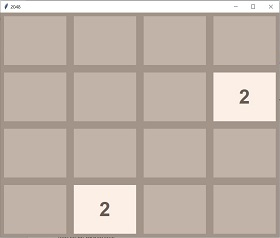

# Task 1

Alright! I'm gonna presume you lost. But don't worry, you have a powerful AI algorithm on your side. Take a look at this [documentation](http://ccg.doc.gold.ac.uk/ccg_old/papers/browne_tciaig12_1.pdf) and your old homework in order to refresh your memory and let's defeat this infamous game once and for all!
<br>
The Monte Carlo Search Tree should have the starting position of the game as a root node and the ending positions (classified as winning or losing) as leafs. The code cells below are there to guide you, but feel free to disregard them and come up with your own approach.
<br>
Before you start, look at this meme:
<br>
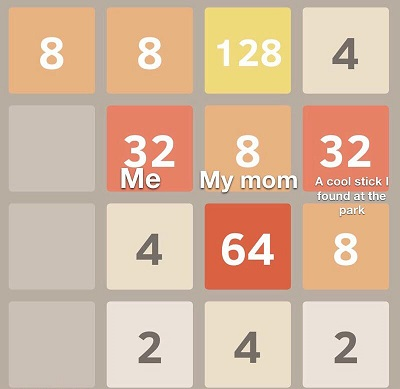
<br>
Ok, I think you're ready now! Go cheat your way into winning!

In [44]:
import numpy as np

def mcts_move(board, searches_per_move, search_length):
    # Declare a list called first_moves which contains the available moves
    first_moves = [move_down, move_left, move_right, move_up]
    # Declare a list called scores which contains the corresponding scores obtained by using the moves in first_moves
    # (should be initialized with zeros)
    scores = np.zeros(4)
    
    # Try each possible move as a first move
    for first_index in range(4):
        first_move = first_moves[first_index]
        first_board, first_valid, first_score = first_move(board)
        
        # If the move is valide, a new tile will be added and the score will be increased
        if first_valid:
            first_board = add_new_tile(first_board)
            scores[first_index] += first_score
        # If not, just continue
        else:
            continue
            
        # Once the first move has been played, a number of searches must be made per move
        for later_moves in range(searches_per_move):
            # Set the variable move_number equal to the number of moves that have been played so far
            # Make a copy of your board (using np.copy()) and set a boolean value is_valid to True
            move_number = 1
            search_board = np.copy(first_board)
            is_valid = True
            
            # While the game is valid and the move number is less than the search length, make random moves. If the 
            # random move is valid: add a new tile, increase the score and the number of moves.
            while is_valid and move_number < search_length:
                search_board, is_valid, score = random_move(search_board)
                scores[first_index] += score
                move_number += 1
                
    # Return the final board and its validity
    best_move_index = np.argmax(scores)
    best_move = first_moves[best_move_index]
    final_board, position_valid, final_score = best_move(board)
    return final_board, position_valid

Now go back to the Display class and uncomment the marked line and block of code. When you're ready, play the game again. This time, use the key "q" to let the MCTS player make a move and the key "p" to fast forward and let the MCTS player take over. Enjoy your victory!

In [46]:
gamegrid = Display()